In [1]:
import numpy as np
import torch
import torch.nn as nn

from nets import GraphNN_KNN_v1, EdgeClassifier_v1
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, average_precision_score
from torch_geometric.data import DataLoader
from preprocessing import preprocess_dataset
from tqdm import tqdm


def predict_one_shower(shower, graph_embedder, edge_classifier):
    embeddings = graph_embedder(shower)
    edge_labels_true = (shower.y[shower.edge_index[0]] == shower.y[shower.edge_index[1]]).view(-1)
    edge_data = torch.cat([
        embeddings[shower.edge_index[0]],
        embeddings[shower.edge_index[1]]
    ], dim=1)
    edge_labels_predicted = edge_classifier(edge_data).view(-1)

    return edge_labels_true, edge_labels_predicted

In [2]:
import hdbscan
from hdbscan import plots as hdbscan_plot
import networkx as nx
from clustering import preprocess_torch_shower_to_nx
import seaborn as sns
import matplotlib.pyplot as plt

min_cl = 40
cl_size = min_cl

In [3]:
datafile='../data/train_200_preprocessed__.pt'
device = torch.device("cpu")

In [4]:
showers = torch.load(datafile)

In [5]:
input_dim = showers[0].x.shape[1]
edge_dim = showers[0].edge_features.shape[1]
hidden_dim = 32
output_dim = 32
num_layers_emulsion = 5
num_layers_edge_conv = 3
min_samples_core = 4

graph_embedder = GraphNN_KNN_v1(
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    edge_dim=edge_dim,
    num_layers_emulsion=num_layers_emulsion,
    num_layers_edge_conv=num_layers_edge_conv,
    input_dim=input_dim,
).to(device)
edge_classifier = EdgeClassifier_v1(
    input_dim=2 * output_dim + edge_dim,
).to(device)

In [6]:
shower = showers[0]

G = preprocess_torch_shower_to_nx(
    shower,
    graph_embedder=graph_embedder,
    edge_classifier=edge_classifier,
    threshold=300,
    add_noise=0.,
    baseline=True
)

100%|██████████| 200/200 [00:00<00:00, 200.64it/s]


In [7]:
connected_components = []
for cnn in nx.connected_components(nx.Graph(G)):
    if len(cnn) > min_cl:
        print(len(cnn), end=", ")
        connected_components.append(nx.DiGraph(G.subgraph(cnn)))
connected_component = connected_components[4]

287, 254, 438, 366, 2015, 1083, 712, 490, 4617, 388, 3164, 225, 114, 3759, 4626, 469, 1456, 3425, 849, 605, 103, 2626, 2974, 94, 555, 1562, 365, 530, 1656, 3358, 52, 1185, 91, 629, 81, 848, 500, 1565, 62, 73, 1442, 266, 429, 1717, 215, 218, 71, 715, 3227, 264, 260, 1010, 556, 393, 494, 755, 203, 71, 295, 469, 1003, 231, 844, 999, 762, 110, 120, 305, 2393, 217, 543, 47, 119, 563, 48, 654, 104, 83, 440, 345, 48, 349, 155, 614, 130, 502, 536, 415, 41, 469, 144, 294, 146, 1075, 1164, 68, 513, 1150, 63, 125, 236, 902, 255, 1543, 214, 154, 1081, 142, 90, 218, 44, 982, 394, 141, 69, 2296, 175, 140, 84, 47, 418, 545, 

## Viz linkage trees

In [8]:
distance_matrix = nx.adjacency_matrix(nx.Graph(connected_component)).toarray().astype(np.float64)
distance_matrix[distance_matrix == 0.] = np.inf
clusterer = hdbscan.HDBSCAN(min_cluster_size=cl_size,
                            min_samples=min_samples_core,
                            metric="precomputed",
                            core_dist_n_jobs=-1)  # precomputed
clusterer.fit(distance_matrix);

/root/miniconda/lib/python3.6/site-packages/hdbscan/hdbscan_.py:103: UserWarning: The minimum spanning tree contains edge weights with value infinity. Potentially, you are missing too many distances in the initial distance matrix for the given neighborhood size.
  'size.', UserWarning)


In [9]:
from custom_hdbscan import run_hdbscan
ewm_clusters, ewm_hdbscan, ewm_linkage = run_hdbscan(connected_component, cl_size=40)
ewm_linkage = np.array(ewm_linkage)

100%|██████████| 2014/2014 [00:00<00:00, 3709.93it/s] 


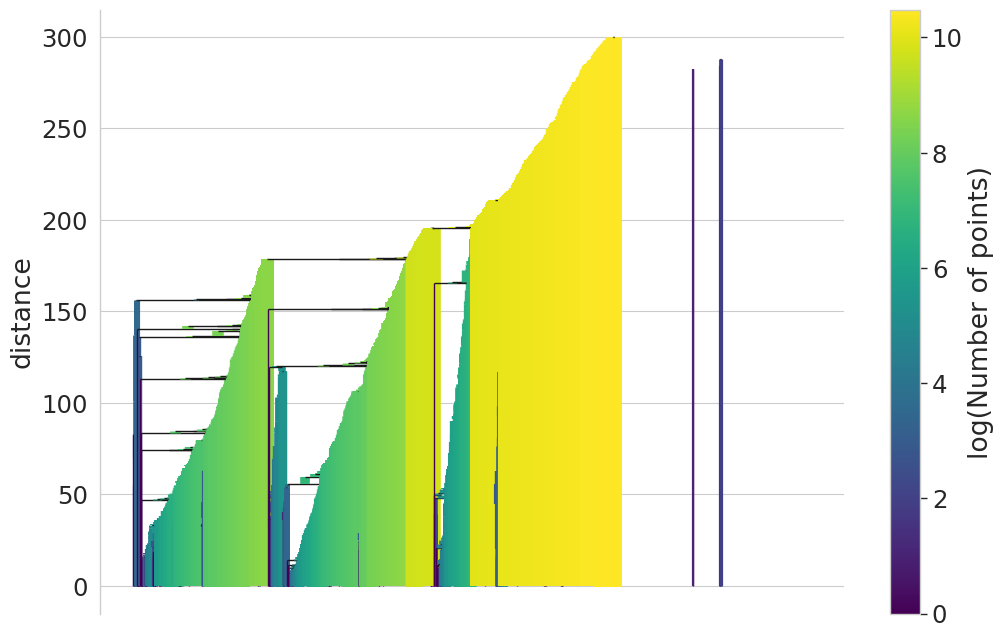

In [10]:
sns.set(context='paper', style="whitegrid", font_scale=2)
plt.figure(figsize=(12, 8), dpi=100)
clusterer.single_linkage_tree_.plot()
plt.savefig("hdbscan_single_linkage.pdf", bbox_inches='tight')
plt.show()

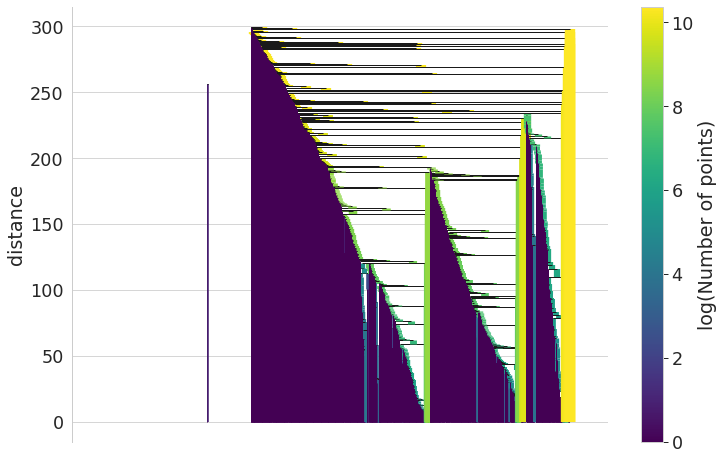

In [11]:
plt.figure(figsize=(12, 8))
hdbscan.plots.SingleLinkageTree(ewm_linkage).plot()
plt.savefig("ewm_single_linkage.pdf", bbox_inches='tight')
plt.show()

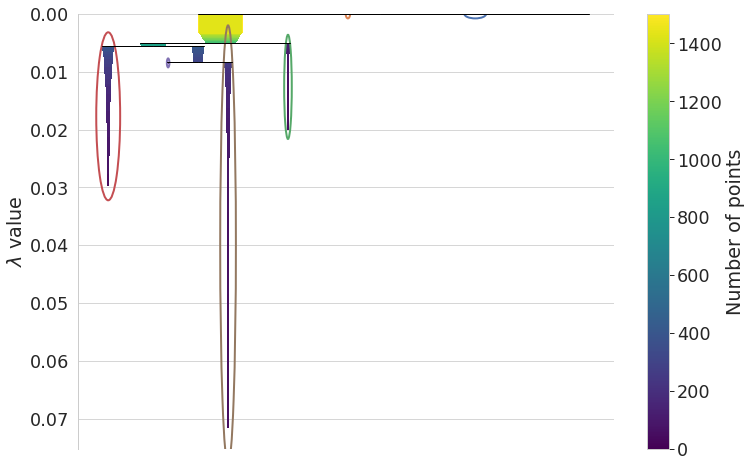

In [12]:
plt.figure(figsize=(12, 8))
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))
plt.savefig("hdbscan_condensed.pdf", bbox_inches='tight')
plt.show()

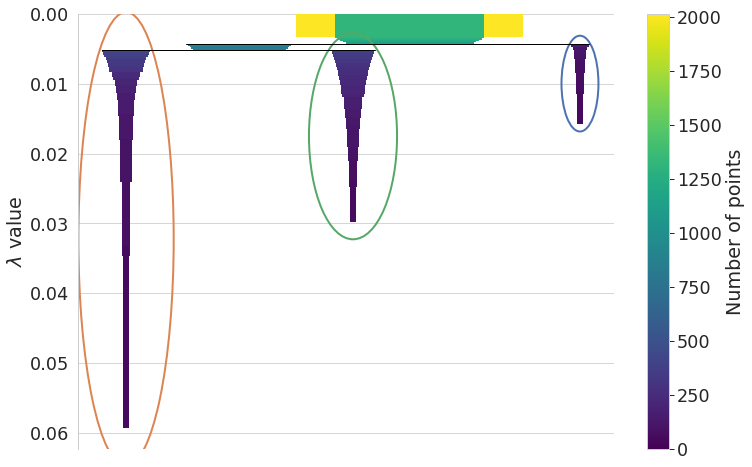

In [13]:
from hdbscan._hdbscan_tree import condense_tree
plt.figure(figsize=(12, 8))
hdbscan.plots.CondensedTree(condense_tree(ewm_linkage, 40)).plot(
    select_clusters=True,
    selection_palette=sns.color_palette('deep', 8)
)
plt.savefig("ewn_condensed.pdf", bbox_inches='tight')
plt.show()

## Viz graph itself

In [15]:
AVAILABLE_COLORS = [
    '#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#42d4f4', 
    'grey', '#469990', 'black', '#9A6324', '#fffac8', '#800000', 
    '#aaffc3', '#000075', '#a9a9a9', '#000000'
]
import copy
from celluloid import Camera
def plot_graphx(nodes: list, nodes_order: list, azim=-84, elev=10):
    """
    Function for plotting shower
    """
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Line3DCollection
    import matplotlib.pyplot as plt
    dZ = 205. / 10000.
    fig = plt.figure(figsize=(12, 12))
    camera = Camera(fig)
    C = plt.cm.Blues(0.9)
    ax = fig.gca(projection='3d')
    # ax.set_xlabel("z")
    # ax.set_ylabel("y")
    # ax.set_zlabel("x") 
    # ax.set_xlim(z0.min(), z1.max())
    # ax.set_ylim(y0.min(), y1.max())
    #  ax.set_zlim(x0.min(), x1.max())

    x0, y0, z0 = [], [], []
    sx, sy = [], []
    colors = []
    AVAILABLE_COLORS
    signal = np.unique([n[1]["signal"] for n in nodes], return_counts=False)
    print(signal)
    map_signal_color = {}
    for i, s in enumerate(signal):
        map_signal_color[s] = AVAILABLE_COLORS[i]
    for i, node_id in enumerate(nodes_order):
        node = nodes[int(node_id)]
        node = node[1]
        if node["signal"] == -1:
            continue # skip noise nodes
        x0.append(node['features']['SX'])
        y0.append(node['features']['SY'])
        z0.append(node['features']['SZ'])
        sx.append(node['features']['TX'])
        sy.append(node['features']['TY'])
        colors.append(map_signal_color[node["signal"]])
        np.unique([n[1]["signal"] for n in nodes_new], return_counts=True)
        if i % 10 == 0:
            print(node_id)
            x0_np, y0_np, z0_np = np.array(x0), np.array(y0), np.array(z0)
            sx_np, sy_np = np.array(sx), np.array(sy)

            x1_np = x0_np + dZ * sx_np
            y1_np = y0_np + dZ * sy_np
            z1_np = z0_np + dZ

            start_points = np.array([z0_np, y0_np, x0_np]).T.reshape(-1, 3)
            end_points = np.array([z1_np, y1_np, x1_np]).T.reshape(-1, 3)

            lc = Line3DCollection(list(zip(start_points, end_points)), colors=colors, alpha=0.9, lw=2)
            ax.set_xlim(z0_np.min(), z1_np.max())
            ax.set_ylim(y0_np.min(), y1_np.max())
            ax.set_zlim(x0_np.min(), x1_np.max())
            ax.view_init(azim=azim, elev=elev)
            ax.add_collection3d(lc)
            camera.snap()
    animation = camera.animate()
    return animation

In [ ]:
connected_component_viz = copy.deepcopy(connected_component)
nodes = list(connected_component_viz.nodes(data=True))
edges = list(connected_component_viz.edges(data=True))

nodes_added = []
for q in ewm_linkage:
    if (not q[0] in nodes_added) and (q[0] < len(connected_component)):
        nodes_added.append(q[0])
    if (not q[1] in nodes_added) and (q[1] < len(connected_component)):
        nodes_added.append(q[1])
        
nodes_mapping = {}
nodes_new = []
for idx, node in enumerate(nodes):
    nodes_mapping[node[0]] = idx
    nodes_new.append((idx, node[1]))
edges_new = []
for idx, edge in enumerate(edges):
    edges_new.append(
        (nodes_mapping[edge[0]], nodes_mapping[edge[1]], edge[2])
    )
    
animation = plot_graphx(nodes_new, nodes_added, azim=-30, elev=20)
animation.save('ewm_clusterer.mp4', dpi=100,
               savefig_kwargs={
                   'frameon': False,
                   'pad_inches': 'tight'
               })

[  4  27  29 136]
434.0
462.0
437.0
91.0
143.0
496.0
1332.0
517.0
1319.0
1360.0
1409.0
1338.0
998.0
1101.0
997.0
1357.0
1420.0
495.0
87.0
1410.0
570.0
1417.0
451.0
1075.0
1370.0
642.0
1232.0
1532.0
1060.0
1988.0
110.0
6.0
328.0
1466.0
1342.0
1694.0
1668.0
1940.0
875.0
1554.0
1406.0
683.0
666.0
1616.0
694.0
1284.0
1890.0
780.0
667.0
803.0
1650.0
566.0
520.0
234.0
59.0
1670.0
285.0
1408.0
1661.0
1123.0
650.0
1611.0
587.0
474.0
626.0
1300.0
1378.0
463.0
796.0
627.0
329.0
754.0
889.0
422.0
1312.0
1756.0
867.0
1226.0
1262.0
1742.0
1560.0
1735.0
1722.0
1005.0
951.0
1313.0
232.0
246.0
300.0
187.0
915.0
932.0
559.0
1626.0
745.0
1329.0
44.0
926.0
1032.0
1871.0
122.0
1031.0
544.0
1139.0
959.0
164.0
1573.0
1813.0
1960.0
257.0
1082.0
1061.0
1419.0
177.0
51.0
917.0
961.0
1146.0
146.0
46.0
487.0
1482.0
190.0
634.0
719.0
853.0
305.0
1079.0
952.0
31.0
740.0
1259.0
920.0
27.0
1646.0
67.0
65.0
68.0
78.0
133.0
144.0
191.0
199.0
208.0
264.0
276.0
307.0
1591.0
345.0
348.0
1038.0
378.0
393.0
416.0
420.0
494

/root/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


In [ ]:
connected_component_viz = copy.deepcopy(connected_component)
nodes = list(connected_component_viz.nodes(data=True))
edges = list(connected_component_viz.edges(data=True))

nodes_added = []
for q in clusterer.single_linkage_tree_.to_numpy():
    if (not q[0] in nodes_added) and (q[0] < len(connected_component)):
        nodes_added.append(q[0])
    if (not q[1] in nodes_added) and (q[1] < len(connected_component)):
        nodes_added.append(q[1])
        
nodes_mapping = {}
nodes_new = []
for idx, node in enumerate(nodes):
    nodes_mapping[node[0]] = idx
    nodes_new.append((idx, node[1]))
edges_new = []
for idx, edge in enumerate(edges):
    edges_new.append(
        (nodes_mapping[edge[0]], nodes_mapping[edge[1]], edge[2])
    )

animation = plot_graphx(nodes_new, nodes_added, azim=-30, elev=20)
animation.save('vanilla_clusterer.mp4', dpi=100,
               savefig_kwargs={
                   'frameon': False,
                   'pad_inches': 'tight'
               })

[-1  0  1  2]
434.0
462.0
437.0
91.0
143.0
496.0
1332.0
517.0
1319.0
1360.0
1409.0
1338.0
998.0
1101.0
997.0
1357.0
1420.0
495.0
87.0
1410.0
570.0
1417.0
451.0
1075.0
1370.0
642.0
1232.0
1532.0
1060.0
1988.0
110.0
6.0
328.0
1466.0
1342.0
1694.0
1668.0
1940.0
875.0
1554.0
1406.0
683.0
666.0
1616.0
694.0
1284.0
1890.0
780.0
667.0
803.0
1650.0
566.0
520.0
234.0
59.0
1670.0
285.0
1408.0
1661.0
1123.0
650.0
1611.0
587.0
474.0
626.0
1300.0
1378.0
463.0
796.0
627.0
329.0
754.0
889.0
422.0
1312.0
1756.0
867.0
1226.0
1262.0
1742.0
1560.0
1735.0
1722.0
1005.0
951.0
1313.0
232.0
246.0
300.0
187.0
915.0
932.0
559.0
1626.0
745.0
122.0
164.0
257.0


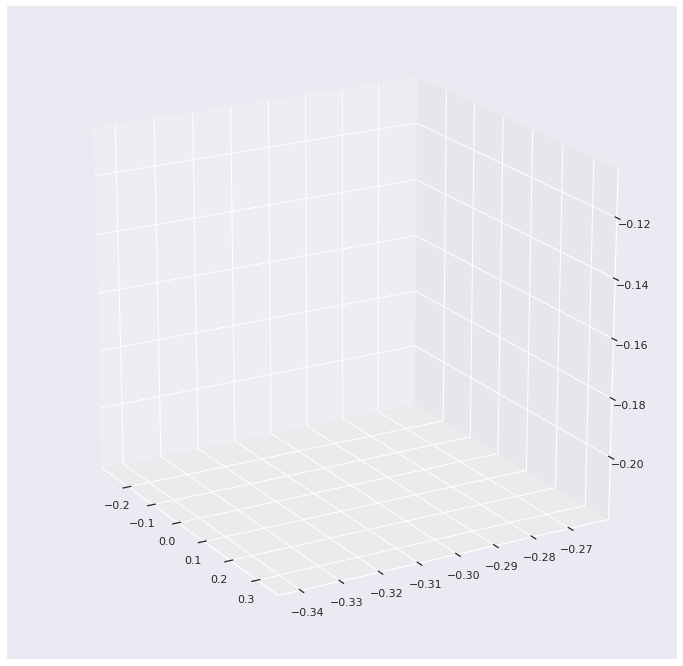

In [17]:
connected_component_viz = copy.deepcopy(connected_component)
nodes = list(connected_component_viz.nodes(data=True))
edges = list(connected_component_viz.edges(data=True))

nodes_added = []
for q in ewm_linkage:
    if (not q[0] in nodes_added) and (q[0] < len(connected_component)):
        nodes_added.append(q[0])
    if (not q[1] in nodes_added) and (q[1] < len(connected_component)):
        nodes_added.append(q[1])
        
ewm_labels = np.full_like(clusterer.labels_, -1)
for c, cluster in enumerate(ewm_clusters):
    for node in cluster.nodes:
        ewm_labels[nodes_mapping[node]] = c
        
nodes_mapping = {}
nodes_new = []
for idx, node in enumerate(nodes):
    nodes_mapping[node[0]] = idx
    nodes_new.append((idx, node[1]))
    
ewm_labels = np.full_like(clusterer.labels_, -1)
for c, cluster in enumerate(ewm_clusters):
    for node in cluster.nodes:
        ewm_labels[nodes_mapping[node]] = c
        
for idx, node in enumerate(nodes_new):
    node[1]["signal"] = ewm_labels[idx]
    
edges_new = []
for idx, edge in enumerate(edges):
    edges_new.append(
        (nodes_mapping[edge[0]], nodes_mapping[edge[1]], edge[2])
    )
    
    
animation = plot_graphx(nodes_new, nodes_added, azim=-30, elev=20)
animation.save('ewm_clusterer_with_labels.mp4')

[-1  0  1  2  3  4  5]
434.0
82.0
449.0
475.0
497.0
509.0
1385.0
532.0
1331.0
473.0
1442.0
997.0
1629.0
1457.0
453.0
1496.0
1662.0
1075.0
2.0
1581.0
1671.0
1359.0
1401.0
225.0
508.0
958.0
642.0
1387.0
1484.0
630.0
1640.0
1617.0
681.0
620.0
294.0
1458.0
1919.0
175.0
674.0
631.0
803.0
1951.0
585.0
245.0
218.0
1669.0
1543.0
2009.0
579.0
665.0
712.0
658.0
812.0
1590.0
38.0
1577.0
185.0
1503.0
1605.0
589.0
325.0
460.0
1538.0
627.0
1717.0
1527.0
1778.0
117.0
1814.0
796.0
44.0
295.0
1676.0
1434.0
1381.0
121.0
168.0
1645.0
1679.0
1874.0
1885.0
108.0
874.0
1269.0
1231.0
1241.0
1253.0
1479.0
1415.0
1309.0
1110.0
1134.0
1065.0
1095.0
1202.0
1219.0
1175.0
1516.0
2003.0
1886.0
1869.0
1972.0
1989.0
1943.0
1957.0
1623.0
1689.0
1540.0
1709.0
1796.0
1788.0
1781.0
279.0
303.0
222.0
264.0
371.0
390.0
338.0
393.0
880.0
909.0
807.0
999.0
1026.0
933.0
979.0


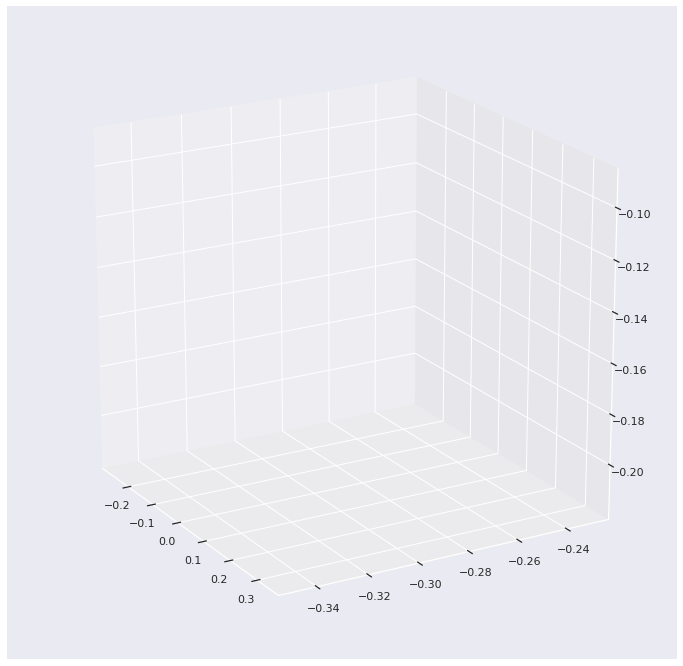

In [18]:
connected_component_viz = copy.deepcopy(connected_component)
nodes = list(connected_component_viz.nodes(data=True))
edges = list(connected_component_viz.edges(data=True))

nodes_added = []
for q in clusterer.single_linkage_tree_.to_numpy():
    if (not q[0] in nodes_added) and (q[0] < len(connected_component)):
        nodes_added.append(q[0])
    if (not q[1] in nodes_added) and (q[1] < len(connected_component)):
        nodes_added.append(q[1])
        
nodes_mapping = {}
nodes_new = []
for idx, node in enumerate(nodes):
    nodes_mapping[node[0]] = idx
    nodes_new.append((idx, node[1]))
    node[1]["signal"] = clusterer.labels_[idx]
    
edges_new = []
for idx, edge in enumerate(edges):
    edges_new.append(
        (nodes_mapping[edge[0]], nodes_mapping[edge[1]], edge[2])
    )

animation = plot_graphx(nodes_new, nodes_added, azim=-30, elev=20)
animation.save('vanilla_clusterer_with_labels.mp4')